In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Variable
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import numpy as np
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
df = pd.read_csv('../data/comple_pre.csv')

In [4]:
df.drop(df.columns[0], axis=1, inplace=True)

In [5]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(targets[i + seq_length])
    return np.array(X), np.array(y)

# 학습 및 테스트 데이터셋 설정
train_ds = df.iloc[:55623, :]
test_ds = df.iloc[55623:, :]

train_y = train_ds.iloc[:, 0].values
train_x = train_ds.iloc[:, 1:].values

test_y = test_ds.iloc[:, 0].values
test_x = test_ds.iloc[:, 1:].values

seq_length = 60

# 학습 데이터 시퀀스 생성
train_x, train_y = create_sequences(train_x, train_y, seq_length)

# 테스트 데이터 시퀀스 생성
test_x, test_y = create_sequences(test_x, test_y, seq_length)

# 텐서로 변환
train_x_tensor_final = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor_final = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1)
test_x_tensor_final = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor_final = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(train_x_tensor_final, train_y_tensor_final)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=True,  
                        drop_last=True)

In [6]:
class LSTM_Jun(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size_1, hidden_size_2,  dropout, seq_length):
        super(LSTM_Jun, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.seq_length = seq_length
        self.dropout = dropout

        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size_1, dropout=dropout, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size_1, hidden_size=hidden_size_2, dropout=dropout, batch_first=True)
        self.layer_out = nn.Linear(hidden_size_2, num_classes)
        self.relu = nn.ReLU()  # Activation Func

    def forward(self, x):
        device = x.device  # Ensure device is correct
        h_0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size_1)).to(device)
        c_0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size_1)).to(device)
        
        h_0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size_2)).to(device)
        c_0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size_2)).to(device)

        output, (hn_1, cn_1) = self.lstm_1(x, (h_0_1, c_0_1))
        output, (hn_2, cn_2) = self.lstm_2(output, (h_0_2, c_0_2))
        out = hn_2[-1]  # Use the last hidden state
        out = self.relu(out)
        out = self.layer_out(out)  # Output layer
        return out


In [7]:
# 파이토치 모델을 사이킷런 인터페이스에 맞게 래핑
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_classes=1, input_size=32, hidden_size_1=100, hidden_size_2=200, dropout=0, seq_length=60, learning_rate=0.001, epochs=10000):
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.seq_length = seq_length
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = LSTM_Jun(num_classes, input_size, hidden_size_1, hidden_size_2, dropout, seq_length).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).view(-1, self.seq_length, self.input_size).to(device)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
        for epoch in range(self.epochs):
            self.model.train()
            outputs = self.model(X)
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if epoch % 200 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")
    
    def predict(self, X):
        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32).view(-1, self.seq_length, self.input_size).to(device)
        outputs = self.model(X)
        return outputs.detach().cpu().numpy()


In [ ]:
import skorch
from skorch import NeuralNetRegressor

regre = NeuralNetRegressor()



In [ ]:
# # 샘플 데이터 생성
# X, y = make_regression(n_samples=1200, n_features=32, noise=0.1, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 학습 데이터 시퀀스 생성
# train_x, train_y = create_sequences(X_train, y_train, seq_length)

# # 테스트 데이터 시퀀스 생성
# test_x, test_y = create_sequences(X_test, y_test, seq_length)

# # 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
# param_grid = {
#     'hidden_size_1': [100, 200, 300, 400, 500],
#     'hidden_size_2': [100, 200, 300, 400, 500],
#     'dropout': [0, 0.2, 0.5, 0.8],
#     'learning_rate': [0.01, 0.005, 0.001, 0.0005, 0.0001]
# }

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# clf = GridSearchCV(PyTorchRegressor(input_size=32, seq_length=60), param_grid, cv=3, scoring='neg_mean_squared_error')
# clf.fit(train_x, train_y)

# # 최적의 파라미터 출력
# print("Best parameters found: ", clf.best_params_)

# # 테스트 데이터에 대한 예측 및 정확도 평가
# y_pred = clf.predict(test_x)
# print("Test MSE: ", mean_squared_error(test_y, y_pred))

In [7]:
# hidden_size_1 = clf.best_params_['hidden_size_1']
# hidden_size_2 = clf.best_params_['hidden_size_2']
# learning_rate = clf.best_params_['learning_rate']
# dropout = clf.best_params_['dropout']

hidden_size_1 = 400
hidden_size_2 = 400
learning_rate = 0.0005
dropout = 0.5
num_epochs = 200
input_size = 32
num_classes = 1

verbose = 10
patience = 10

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)
    model.train()
    
    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
        
            x_train = x_train.to(device)     
            y_train = y_train.to(device)
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train.view(-1, 1))         
            
            # cost로 H(x) 개선
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
        
           
    return model.eval(), train_hist

In [8]:
LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size_1, hidden_size_2, seq_length=train_x_tensor_final.shape[1], dropout=0.5).to(device)


c:\Users\CSK\Documents\coder\NOx-with-TFT\venv\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
model, train_hist = train_model(LSTM_Jun, dataloader, num_epochs = num_epochs, lr = learning_rate, verbose = 1, patience = 50)

Epoch: 0000 train loss : 0.0900
Epoch: 0001 train loss : 0.0557
Epoch: 0002 train loss : 0.0450
Epoch: 0003 train loss : 0.0378
Epoch: 0004 train loss : 0.0286
Epoch: 0005 train loss : 0.0336
Epoch: 0006 train loss : 0.0274
Epoch: 0007 train loss : 0.0280
Epoch: 0008 train loss : 0.0231
Epoch: 0009 train loss : 0.0201
Epoch: 0010 train loss : 0.0217
Epoch: 0011 train loss : 0.0178
Epoch: 0012 train loss : 0.0209
Epoch: 0013 train loss : 0.0213
Epoch: 0014 train loss : 0.0183
Epoch: 0015 train loss : 0.0147
Epoch: 0016 train loss : 0.0159
Epoch: 0017 train loss : 0.0163
Epoch: 0018 train loss : 0.0126
Epoch: 0019 train loss : 0.0152
Epoch: 0020 train loss : 0.0170
Epoch: 0021 train loss : 0.0158
Epoch: 0022 train loss : 0.0115
Epoch: 0023 train loss : 0.0110
Epoch: 0024 train loss : 0.0119
Epoch: 0025 train loss : 0.0107
Epoch: 0026 train loss : 0.0088
Epoch: 0027 train loss : 0.0117
Epoch: 0028 train loss : 0.0084
Epoch: 0029 train loss : 0.0085
Epoch: 0030 train loss : 0.0076
Epoch: 0

In [10]:
def inverse_zscore(z, mean, std):
    return z * std + mean

test_predict = LSTM_Jun(test_x_tensor_final.to(device)) 
predict_data = test_predict.data.detach().cpu().numpy() 
pre_data = inverse_zscore(predict_data, 14.836815923101076, 7.559993882011501) 
real_data = test_y_tensor_final.data.numpy() 
re_data = inverse_zscore(real_data, 14.836815923101076, 7.559993882011501) 

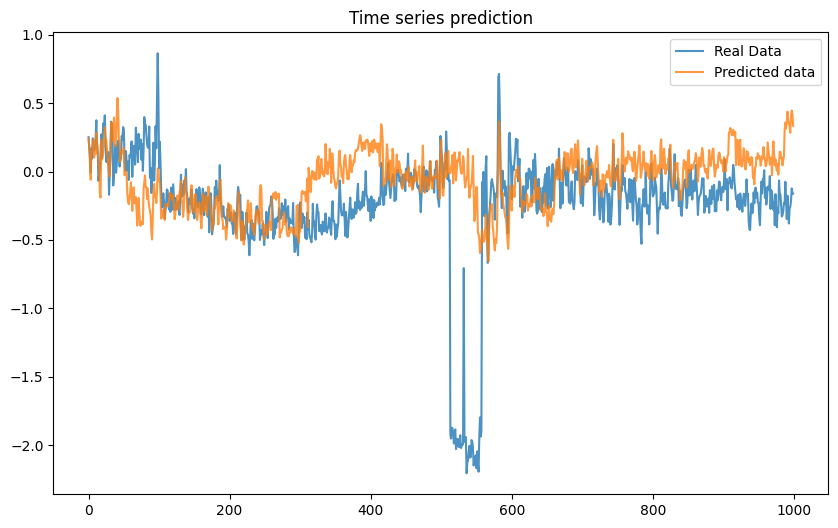

In [11]:
strt = 3000
end = 4000
plt.figure(figsize = (10,6)) 

plt.plot(real_data[strt:end], label = 'Real Data', alpha=0.8)
plt.plot(predict_data[strt:end], label = 'Predicted data', alpha=0.8)

plt.title('Time series prediction')
plt.legend()
plt.show()

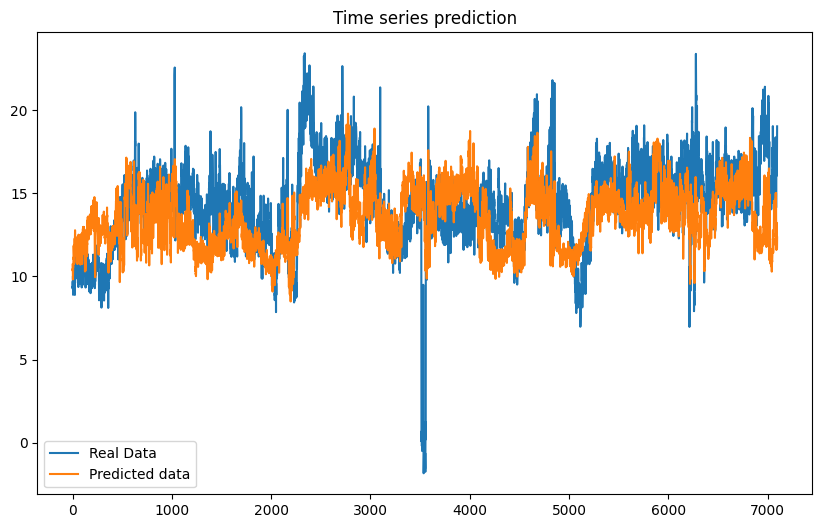

In [12]:
plt.figure(figsize = (10,6)) 
plt.plot(re_data, label = 'Real Data')
plt.plot(pre_data, label = 'Predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

In [13]:
mse = mean_squared_error(re_data, pre_data)
print("MSE:", mse)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(re_data, pre_data)
print("MAE:", mae)

# R^2 Score
r2 = r2_score(re_data, pre_data)
print("R^2 Score:", r2)

# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(re_data, pre_data)
print("MAPE:", mape)

MSE: 6.82982
RMSE: 2.6133924
MAE: 1.9530922
R^2 Score: 0.03428393602371216
MAPE: 0.7142147


In [ ]:
import numpy as np

class PSO(object):
    """
    Class implementing PSO algorithm
    """
    def __init__(self, func, init_pos, n_particles):
        """
        Initialize the key variables.
        
        Args:
            fun (function): the fitness function to optimize
            init_pos(array_like):
            n_particles(int): the number of particles of the swarm.
        """
        self.func = func
        self.n_particles = n_particles
        self.init_pos = init_pos
        self.particle_dim = len(init_pos)
        self.particles_pos = np.random.uniform(size=(n_particles, self.particle_dim)) \
                            * self.init_pos
        self.velocities = np.random.uniform(size=(n_particles, self.particle_dim))
        #Initilize the best positions
        self.g_best = init_pos
        self.p_best = self.particles_pos
        
    
    def update_position(self, x, v):
        """
        Update particle position
        
        Args:
            x (array-like): particle current position
            v (array-like): particle current velocity
        
        Returns:
            The updated position(array-like)
        """
        x = np.array(x)
        v = np.array(v)
        new_x = x + v
        return new_x
    
    
    def update_velocity(self, x, v, p_best, g_best, c0=0.5, c1=1.5, w=0.75):
        """
            Update particle velocity
            
            Args:
                x(array-like): particle current position
                v (array-like): particle current velocity
                p_best(array-like): the best position found so far for a particle
                g_best(array-like): the best position regarding all the particles found so far
                c0 (float): the congnitive scaling constant, 인지 스케일링 상수
                c1 (float): the social scaling constant
                w (float): the inertia weight, 관성 중량
                
            Returns:
                The updated velocity (array-like).
        """
        x = np.array(x)
        v = np.array(v)
        assert x.shape == v.shape, "Position and velocity must have same shape."
        # a random number between 0 and 1
        r = np.random.uniform()
        p_best = np.array(p_best)
        g_best = np.array(g_best)
        
        new_v = w*v + c0*r*(p_best - x) + c1*r*(g_best-x)
        return new_v
    
    
    def optimize(self, maxiter=200):
        """
        Run the PSO optimization process utill the stoping critera is met.
        Cas for minization. The aim is to minimize the cost function
        
        Args:
            maxiter (int): the maximum number of iterations before stopping the optimization
            
        Returns:
            The best solution found (array-like)
        """
        for _ in range(maxiter):
            for i in range(self.n_particles):
                x = self.particles_pos[i]
                v = self.velocities[i]
                p_best = self.p_best[i]
                self.velocities[i] = self.update_velocity(x, v, p_best, self.g_best)
                self.particles_pos[i] = self.update_position(x,v)
                # Update the besst position for particle i
                if self.func(self.particles_pos[i]) < self.func(p_best):
                    self.p_best[i] = self.particles_pos[i]
                # Update the best position overall
                if self.func(self.particles_pos[i]) < self.func(self.g_best):
                    self.g_best = self.particles_pos[i]
                    
        return self.g_best, self.func(self.g_best)
    
    
def sphere(x):
    """
        In 3D : f(x,y,z) = x² + y² + z²
    """
    return np.sum(np.square(x))